In [12]:
import torch
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import deepxde.deepxde as dde
import deepxde.deepxde.backend as bkd
from datasets import makeTesting
from datasets import parallel_solver, diffusion_reaction_solver
from utils.func import dirichlet, periodic
from utils.PDETriple import PDETripleCartesianProd

date = time.strftime("%Y%m%d-%H-%M-%S", time.localtime())

In [13]:
total_training_vx = 400

if False:
    makeTesting()

In [14]:
def pde(x, y, aux):
    D = 0.01
    k = 0.01
    dy_t = dde.grad.jacobian(y, x[1], j=1)
    dy_xx = dde.grad.hessian(y, x[1], j=0)
    out = dy_t - D * dy_xx + k * y**2 - aux
    return out

class boundary():
    def __init__(self, loss_coeff = 1, value = 0):
        self.loss_coeff = loss_coeff
        self.value = value
    
    def __call__(self, targets, outputs):
        return self.loss_coeff * (outputs - self.value).abs().mean()

In [15]:
space = dde.data.GRF(1.0, length_scale = 0.1, N= 1000, interp="cubic")

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
vxs = space.eval_batch(space.random(20), np.linspace(0, 1, 101)[:, None])
uxts = parallel_solver(diffusion_reaction_solver, vxs, num_workers = 3)
grid = uxts[0][0].reshape(101 * 101, -1)
uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)


train_vxs = vxs
train_grid = grid
train_uxts = uxts
print(train_vxs.shape, train_grid.shape, train_uxts.shape)

test_data = np.load("datasets/DF_100_0.1_101_101.npz")
test_vxs = test_data["vxs"]
test_grid = test_data["xt"].reshape(-1, 2)
test_uxts = test_data["uxts"].reshape(-1, 101 * 101)
del test_data
print(test_vxs.shape, test_grid.shape, test_uxts.shape)

(20, 101) (10201, 2) (20, 10201)
(100, 101) (10201, 2) (100, 10201)


In [16]:
init_indices = (grid[:, 1] == 0).nonzero()[0]
bound_indices = np.logical_or(grid[:, 0] == 0, grid[:, 0] == 1).nonzero()[0]
boundary_losses = []
boundary_losses.append((init_indices, boundary()))
boundary_losses.append((bound_indices, boundary()))
print(init_indices.shape, bound_indices.shape)

(101,) (202,)


In [17]:
data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = [])

# Net
net = dde.nn.DeepONetCartesianProd(
    [101, 100, 100],
    [2, 100, 100, 100],
    "gelu",
    "Glorot normal",
)

# net.apply_feature_transform(periodic)
net.apply_output_transform(dirichlet)

model = dde.Model(data, net)
model.compile("adam", lr=1E-3, loss= ["mse"], metrics = ["mean l2 relative error"])


Compiling model...
'compile' took 0.001882 s



In [18]:
losshistory, train_state = model.train(iterations=20000, batch_size = 2)
dde.utils.plot_loss_history(losshistory)

Training model...

Step      Train loss    Test loss     Test metric   
0         [4.55e-01]    [2.14e-01]    [1.04e+00]    


KeyboardInterrupt: 

In [ ]:
losshistory.to_pandas().to_csv(f"results/loss_history_{date}_rasg.csv", index=False)

In [ ]:

while len(train_vxs) < total_training_vx:
    # generate some vxs to test
    pde_data = dde.data.TimePDE(geomtime, pde, [], num_domain = 20000)
    eval_pts = np.linspace(0, 1, 101)[:, None] # generate 1000 random vxs
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    func_space = dde.data.GRF(1.0, length_scale = 0.1, N= 1000, interp="linear")
    testing_new_data = dde.data.PDEOperatorCartesianProd(pde_data, func_space, eval_pts, 1000, [0])
    # testing_model = dde.Model(testing_new_data, net)
    a, _, c = testing_new_data.train_next_batch()
    out = model.predict(a, aux_vars = c, operator = pde)
    
    res = np.mean(np.abs(out), axis = 1)
    print(np.mean(res), np.std(res))
    topk_index = np.argpartition(res, -20)[-20:] # select the top 20 vxs
    topk_vxs = a[0][topk_index]
    uxts = parallel_solver(diffusion_reaction_solver, topk_vxs, num_workers = 6)
    uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)

    # then add the new data to the training set, and train the model
    train_vxs = np.concatenate([train_vxs, topk_vxs], axis = 0)
    train_uxts = np.concatenate([train_uxts, uxts], axis = 0)
    
    print(len(train_vxs))
    data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = [])
    
    model = dde.Model(data, net)
    batchsize = len(train_vxs) // 5 if len(train_vxs) != total_training_vx else total_training_vx
    iterations = 20000 if len(train_vxs) != total_training_vx else 50000
    model.compile("adam", 
                  lr=1e-3, 
                  metrics = ["mean l2 relative error"], 
                  decay = ("inverse time", 5000, 0.4))
    losshistory, train_state = model.train(iterations=iterations, batch_size = batchsize)
    pd_frame = losshistory.to_pandas()
    pd_frame = pd.concat([pd.read_csv(f"results/loss_history_{date}_rasg.csv"), pd_frame], axis = 0, ignore_index=True)
    pd_frame.to_csv(f"results/loss_history_{date}_rasg.csv", index=False)
    dde.utils.plot_loss_history(losshistory)
    
torch.save(model.state_dict(), f"results/model_{date}_rasg.pth")

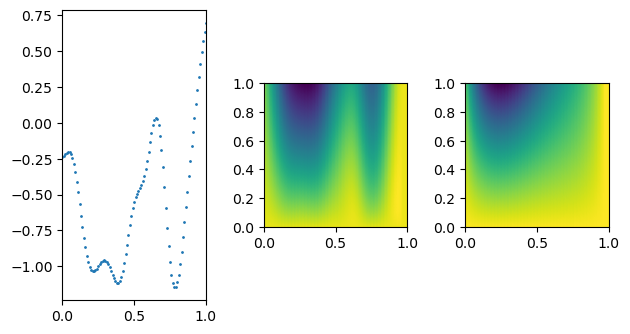

In [36]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3)

v = test_vxs[0]
x = np.linspace(0,1,v.shape[0])

ax1.set_xlim(0,1)
ax1.set_aspect('equal')
ax1.scatter(x, v, s=1)

ut = test_uxts[0]
xt = test_grid

ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_aspect('equal')
ax2.scatter(xt[...,0], xt[...,1], c=ut)

out = model.predict((test_vxs[(0,),...], xt))

ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
ax3.set_aspect('equal')
ax3.scatter(xt[...,0], xt[...,1], c=out)

plt.tight_layout()
plt.show()